In [5]:
import pandas as pd
import backtrader as bt
import yfinance as yf

In [6]:
# 导入数据
dat = yf.Ticker('AAPL')
dat_hist = dat.history(period='1Y')
dat_hist.index = pd.to_datetime(dat_hist.index).normalize()
dat_hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
dat_hist.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-21 00:00:00-04:00,225.470666,226.923894,224.007474,225.351212,34765500
2024-08-22 00:00:00-04:00,226.734745,227.282200,222.862767,223.489853,43695300
2024-08-23 00:00:00-04:00,224.614643,227.162781,223.290802,225.789169,38677300
2024-08-26 00:00:00-04:00,225.709541,226.227137,222.852841,226.127594,30602200
2024-08-27 00:00:00-04:00,224.953068,227.789872,223.848210,226.973663,35934600


# 定义布林带策略
-  **卖出信号**:价格穿过布林带上轨
-  **买入信号**:价格穿过布林带下轨
-  **标准差倍数**:选择2.0倍
-  **周期**:选择近20个交易日

In [7]:
class BOLL_Strategy(bt.Strategy):
    # 定义参数
    params = (
        ('boll_period', 20),
        ('boll_devfactor', 2.0))

    def __init__(self):
        self.order = None
        self.buy_price = None
        self.comm = None

        self.dataclose = self.datas[0].close
        self.boll = bt.indicators.BollingerBands(
            self.dataclose, 
            period=self.p.boll_period, 
            devfactor=self.p.boll_devfactor)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果订单是完成状态 (买入/卖出)
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.comm = order.executed.comm
                print(f"买入执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            elif order.issell():
                print(f"卖出执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            self.bar_executed = len(self) # 记录订单执行时的 bar 数量
        # 如果订单是取消、保证金不足、拒绝等状态
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"订单状态: {order.Status[order.status]} - 日期: {self.data.datetime.date()}")
        self.order = None

    def notify_trade(self, trade):
        # 交易完成（平仓）时调用
        if not trade.isclosed:
            return
        print(f"交易完成 - 毛利润: {trade.pnl:.2f}, 净利润: {trade.pnlcomm:.2f}")

    def next(self):
        current_close = self.dataclose[0]
        last_close = self.dataclose[-1]
        boll_top = self.boll.top[0]
        last_boll_top = self.boll.top[-1]
        boll_mid = self.boll.mid[0]
        boll_bot = self.boll.bot[0]
        last_boll_bot = self.boll.bot[-1]

        # ====买入规则====
        if not self.position:
            if current_close <= boll_bot and last_close >= last_boll_bot:
                self.order = self.buy(size=10) # 假设买入10个单位
                print(f"发出买入信号(穿下线) - 日期：{self.data.datetime.date()}," 
                      f"收盘：{current_close:.2f} - 布林下线：{boll_bot:.2f} - 布林中线{boll_mid:.2f}")
        # ====卖出规则====
        else:
            if current_close >= boll_top and last_close <= last_boll_top:
                self.order = self .close() # 平仓所有仓位 
                print(f"发出平仓信号(穿上线) - 日期：{self.data.datetime.date()}," 
                      f"收盘：{current_close:.2f} - 布林上线：{boll_top:.2f} - 布林中线{boll_mid:.2f}")

        # ====特殊情况====
        if self.p.boll_period > len(self):
            return
        if self.order:
            return

# Cerebro实例化  
- **indicators**:收益率、夏普比率、胜率比、盈亏比、最大回撤

初始资金: 100000.00
发出买入信号(穿下线) - 日期：2024-11-04,收盘：220.98 - 布林下线：221.61 - 布林中线229.39
买入执行 - 日期: 2024-11-05, 价格: 220.77, 成本: 2207.73, 佣金: 1.32
发出平仓信号(穿上线) - 日期：2024-11-26,收盘：234.23 - 布林上线：232.89 - 布林中线226.11
卖出执行 - 日期: 2024-11-27, 价格: 233.64, 成本: 2207.73, 佣金: 1.40
交易完成 - 毛利润: 128.68, 净利润: 125.95
发出买入信号(穿下线) - 日期：2025-01-10,收盘：236.01 - 布林下线：236.95 - 布林中线248.32
买入执行 - 日期: 2025-01-13, 价格: 232.70, 成本: 2327.04, 佣金: 1.40
发出平仓信号(穿上线) - 日期：2025-02-14,收盘：244.00 - 布林上线：243.92 - 布林中线231.31
卖出执行 - 日期: 2025-02-18, 价格: 243.55, 成本: 2327.04, 佣金: 1.46
交易完成 - 毛利润: 108.50, 净利润: 105.64
发出买入信号(穿下线) - 日期：2025-03-10,收盘：226.92 - 布林下线：227.31 - 布林中线238.88
买入执行 - 日期: 2025-03-11, 价格: 223.26, 成本: 2232.64, 佣金: 1.34
发出平仓信号(穿上线) - 日期：2025-07-01,收盘：207.58 - 布林上线：206.54 - 布林中线200.74
卖出执行 - 日期: 2025-07-02, 价格: 208.67, 成本: 2232.64, 佣金: 1.25
交易完成 - 毛利润: -145.90, 净利润: -148.50
发出买入信号(穿下线) - 日期：2025-08-01,收盘：202.15 - 布林下线：205.07 - 布林中线210.60
买入执行 - 日期: 2025-08-04, 价格: 204.28, 成本: 2042.78, 佣金: 1.23
发出平仓信号(穿上线) - 日期：2025-08-07,收盘：2

<IPython.core.display.Javascript object>

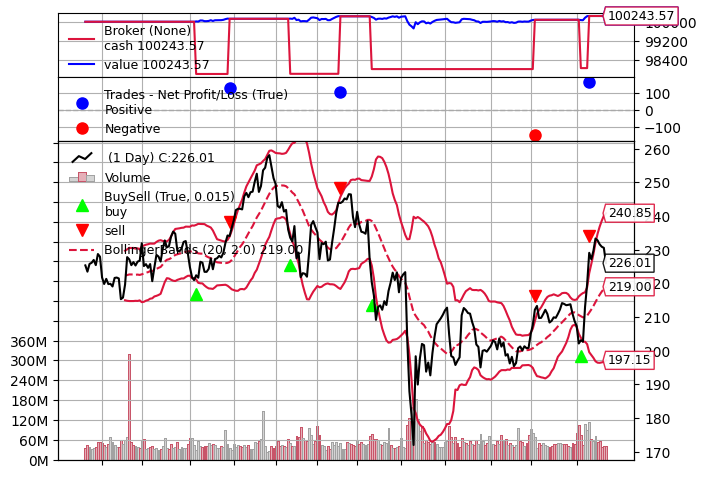

In [8]:
# 创建实例
cerebro = bt.Cerebro()
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns_analyzer', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp_analyzer', timeframe=bt.TimeFrame.Years)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drwa_analyzer')

# 导入数据策略，初始化设置
data = bt.feeds.PandasData(
    dataname=dat_hist,
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data)
cerebro.addstrategy(BOLL_Strategy)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0006)

# 运行策略
print(f"初始资金: {cerebro.broker.getvalue():.2f}")
resuluts = cerebro.run()
thestrat = resuluts[0]
trade_analyzer = thestrat.analyzers.trade_analyzer.get_analysis()
return_analyzer = thestrat.analyzers.returns_analyzer.get_analysis()
sharp_analyzer = thestrat.analyzers.sharp_analyzer.get_analysis()
draw_analyzer = thestrat.analyzers.drwa_analyzer.get_analysis()
print(f"最终资金为：{cerebro.broker.getvalue():.2f}")
print(f"总收益率为：{return_analyzer.get('rtot', 0) * 100:.2f}%")
print(f"夏普比率为：{sharp_analyzer['sharperatio']:.4f}")

total_trades = trade_analyzer.total.closed
winning_trades = trade_analyzer.won.total
win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
print(f"胜率比为：{winning_trades}/{total_trades}，{win_rate:.2f}%")

gross_profit = trade_analyzer.won.pnl.total
gross_loss = abs(trade_analyzer.lost.pnl.total)
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
print(f"盈亏比为：{profit_factor:.2f}")
print(f"最大回撤为：{draw_analyzer.max.drawdown:.2f}%")

%matplotlib inline
cerebro.plot()[0][0]
